## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that we get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image

`1.` 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.query('landing_page == "old_page"').shape[0]

147239

In [4]:
df.query('landing_page == "new_page"').shape[0]

147239

b. Number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [7]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
number_1 = df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]
number_2 = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0]
number_1 + number_2

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now we should only use the rows that we can feel confident in the accuracy of the data - so will delete rows which doesn't match.

In [10]:
index_1 = list(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)
index_2 = list(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index)
df2 = df.copy()
df2.drop(index = index_1,inplace = True)
df2.drop(index = index_2,inplace = True)

In [11]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Checking the shape of the dataframe

In [13]:
df2.shape

(290585, 5)

a. How many unique **user_id**s are in **df2**?

In [14]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.


In [16]:
df2.drop(index = 2893,inplace = True)

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# We have to find mean probability 
df2.groupby('landing_page')['converted'].mean()

landing_page
new_page    0.118808
old_page    0.120386
Name: converted, dtype: float64

In [18]:
prob = (df2.groupby('landing_page')['converted'].mean()[0] + df2.groupby('landing_page')['converted'].mean()[0])/2
prob

0.11880806551510564

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df2.query('landing_page == "new_page"').shape[0]/ df2.shape[0]

0.5000619442226688

e. Considering our results from a. through d. above, we will try to explain below whether there is sufficient evidence to say that the new treatment page leads to more conversions.

In [22]:
# First,let's look if it was enough time to collect the data
#for that,we need to convert 'timestamp' to datetime index
df2['timestamp'] = pd.to_datetime(df2['timestamp'], yearfirst = True)

In [23]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [24]:
# min date
df2['timestamp'].min()

Timestamp('2017-01-02 13:42:05.378582')

In [25]:
# max date
df2['timestamp'].max()

Timestamp('2017-01-24 13:41:54.460509')

In [26]:
# checking if there is only one month
df2['timestamp'].dt.month.unique()

array([1], dtype=int64)

To sum up,what do we have:
 - only one month of observation
 - very low conversion rates
 - convertion rates from 'old_page' (0.118) and 'new_page' (0.120) don't differ much and are practically insignificant.\
In my opinion, we  don't have enough evidence that our new_page is better,it would be better to extend the experiment,but we can go another way 
 
 
 
     

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, let's consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should  null and alternative hypotheses be?  

I think null and alternative hypotheses are obvious:\

$ H_0:p_{old} \ge p_{new}$ or $p_{old} - p_{new} \ge 0 $ \
$ H_1:p_{new} > p_{old}$ or $p_{new} - p_{old} > 0 $ \


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. 


a. What is the **convert rate** for $p_{new}$ under the null? 

In [27]:
df2['converted'].mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [28]:
df2['converted'].mean()

0.11959708724499628

c. What is $n_{new}$?

In [29]:
df2.query('landing_page == "new_page"').shape[0]

145310

d. What is $n_{old}$?

In [30]:
df2.query('landing_page == "old_page"').shape[0]

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
size = df2.query('group == "treatment"').shape[0]
prob = df2['converted'].mean()
new_page_converted = np.random.choice([1, 0], size=size,
                      p=[prob,1-prob])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
size = df2.query('group == "control"').shape[0]
prob = df2['converted'].mean()
old_page_converted = np.random.choice([1, 0], size=size,
                      p=[prob,1-prob])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
new_page_converted.mean() - old_page_converted.mean()

0.0005002861012435439

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [34]:
p_diffs = np.array([])
prob = df2['converted'].mean()
size_control = df2.query('group == "control"').shape[0]
size_treatment = df2.query('group == "treatment"').shape[0]
for _ in tqdm(range(10000)):
    new_page_converted = np.random.choice([1, 0], size=size_treatment,
                      p=[prob,1-prob])
    old_page_converted = np.random.choice([1, 0], size=size_control,
                      p=[prob,1-prob])
    p_diffs = np.append(p_diffs,new_page_converted.mean() - old_page_converted.mean())
    

Just one minute and 18 seconds! Very well! Let's proceed futher

i. Plot a histogram of the **p_diffs**.  Does this plot look like what we expected?

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
p_diffs.mean()

-2.844438001591408e-06

In [40]:
actual_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
(p_diffs > actual_diff).mean()

0.9078

In [41]:
p_diffs.std()

0.001196917245184005

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

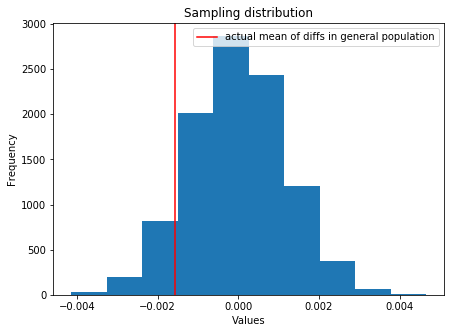

In [43]:
# First,let's visualize some variables
# In our null hypothesis we assume our population mean is centered in zero
# and if we see our statistic in a bulk of a simulate distribution, then this statistic is more likely to be
#from this null 
null_values = np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.figure(figsize =(7,5))
plt.hist(null_values)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Sampling distribution')
plt.axvline(x = actual_diff,color = 'red',label = 'actual mean of diffs in general population')
plt.legend();

By calculating (p_diffs > actual_diff).mean() which is 0.905 we found a p-value,a proportion of the simulated draws that are greater then our observed statistic.In other words,we have a null that a difference in means is equal to zero,so there is no difference in conversion between an old_page and a new_page.We calculated $𝑝_{𝑛𝑒𝑤} - 𝑝_{𝑜𝑙𝑑}$  values,that is our sampling distribution, and then,assuming out hypothesis is true,what is a probability of observing the actual value of the statistic(differences in means in ab_data.csv) in our sampling distribution? And the probability is 0.905,in which case we fail to reject our null hypothesis,so our statistic was not by a chance.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [44]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == "1"').shape[0] 
convert_new = df2.query('landing_page == "new_page" & converted == "1"').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [45]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative = 'smaller')

In [46]:
z_score

1.3109241984234394

In [47]:
p_value

0.9050583127590245

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score test is a type of hypothesis test for two population proportions, and is  used when you want to know whether two populations  differ significantly on some  characteristic [source](https://www.socscistatistics.com/tests/ztest/)\
After finding z-score,we need to find out if the z-score falls into the "rejection region",our $\alpha$ is 5% level,so in the table below it is associated with z alpha/2 or 1.96. If our found z-score falls beyond the value of  1.96,we have all rights to reject the null hypothesis,in our case we fail to reject the null - 1.31 < 1.96\
And our p-value is exactly the same as calculated before

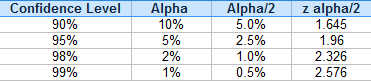

In [48]:
Image('z-alpha.png')

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Obviously,our task is to classify whether the person wil be converted or not,so this is a binary classification and logistic regression is the most suitable for this task

b. The goal is to use **statsmodels** to fit the regression model  to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [50]:
df2['intercept'] = 1
df2['ab_page'] = df['group'].replace({'control':0,'treatment':1})

In [52]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [53]:
logreg = sm.Logit(df2['converted'],df2[['intercept','ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [55]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        11:36:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [59]:
# We don't interested in intercept,but in ab_page,so in order to explain it we need to exponentiate
np.exp(-0.015)

0.9851119396030626

So,what does it mean? Converce is 0.985 more likely to happen if we receive a new_page (1 was for treatment group) holding all else constant,meaning we still can't reject the null hypothesis from Part II

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

The null hypothesis in our model is that the new_page is better than an old-page.\
In our logistic regression model,looking at the p-value,if the p-values are less than 0.05, this suggests there is a statistically significant relationship between the variable and the response variable,in our case, **ab_page** has a p-value of 0.19 which is more then 0.05,so new_page has no significant relationship with conversion,therefore,we don;t have enought evidence to state that our new_page is better


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

In my opinion, I would consider personal offers,discounts,for example,some 5-10% discount for new individuals,in might increase conversion, but we must also consider other sides,our budget and revenue
Also, it may be  a good idea to experiment with time of the day,probably people are more likely so explore something new during weekends


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [62]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [63]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [65]:
# Let's look how many unique countries we have
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [71]:
df_new[['UK','US','CA']] = pd.get_dummies(df_new[['country']])

In [72]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [73]:
#Let's get CA as a base 
logreg = sm.Logit(df_new['converted'],df_new[['UK','US','intercept','ab_page']]).fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 Apr 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:58:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

None of the above values has statistically significant relationship with conversion,our p-values are more then 0.05,recall that we are not interested in interception,also our z-score doesn't fall beyond the [-1.96,+1.96] rejection interval.
We could exponentiate and draw some conclusions about countries, but  I think it is not necessary,instead, let's visualize correlations between variables,just to be sure we were right

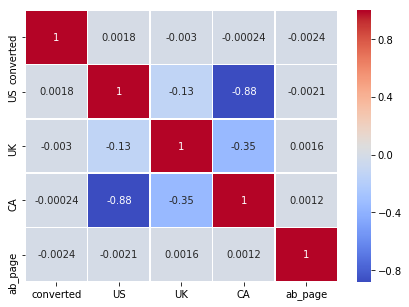

In [88]:
import seaborn as sns
plt.figure(figsize = (7,5))
sns.heatmap(df_new[['converted','US','UK','CA','ab_page']].corr(),annot = True,
            linewidth = 0.5,cmap = 'coolwarm');

Almost zero correlation between converted and other variables.Zero correlations does not mean that variables have no relations, but in our case,we can be sure our  p-values and z-score were calculated in a right way.\

Let's add some variables realated with time to check our assumptions about conversion:
 - morning: 7 - 11
 - midday: 12 - 15
 - evening: 16 - 20 
 - night : 0 - 6

In [93]:
df_new['morning']  = df_new['timestamp'].dt.hour.apply(lambda hour:int(hour >= 7 and hour <= 11 )) 
df_new['midday']  = df_new['timestamp'].dt.hour.apply(lambda hour:int(hour >= 12 and hour <= 19 ))
df_new['evening']  = df_new['timestamp'].dt.hour.apply(lambda hour:int(hour >= 19 and hour <= 23 )) 
df_new['night']  = df_new['timestamp'].dt.hour.apply(lambda hour:int(hour >= 23 and hour <= 6 )) 


In [94]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA,morning,midday,evening,night
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0,0


Looks great,let's  look on our conversion rate, and then proceed to training our regression with new variables!

In [109]:
df_new.groupby(['morning','landing_page'])['converted'].mean()

morning  landing_page
0        new_page        0.118673
         old_page        0.120146
1        new_page        0.119324
         old_page        0.121295
Name: converted, dtype: float64

In [110]:
df_new.groupby(['midday','landing_page'])['converted'].mean()

midday  landing_page
0       new_page        0.117587
        old_page        0.120327
1       new_page        0.121234
        old_page        0.120505
Name: converted, dtype: float64

In [111]:
df_new.groupby(['evening','landing_page'])['converted'].mean()

evening  landing_page
0        new_page        0.118169
         old_page        0.120803
1        new_page        0.121253
         old_page        0.118811
Name: converted, dtype: float64

In [112]:
df_new.groupby(['night','landing_page'])['converted'].mean()

night  landing_page
0      new_page        0.118808
       old_page        0.120386
Name: converted, dtype: float64

Interesting,we have almost equal proportions among four daytimes of those who converted, and none of the individual converted during the night! If only we had data for longer period of time,say two ore more months, we would have seen different results,in my opinion\
Let's create some additional variables to sum up our observations

In [97]:
df_new['holiday'] = (df_new['timestamp'].dt.dayofweek >= 5).astype(int)
df_new['day_of_week'] = (df_new['timestamp'].dt.dayofweek).astype(int)

In [123]:
df_new.groupby(['landing_page','holiday','day_of_week'])['converted'].agg([np.mean])

mean
landing_page holiday day_of_week          
new_page     0       0            0.119491
                     1            0.122339
                     2            0.118837
                     3            0.118209
                     4            0.117538
             1       5            0.117058
                     6            0.117431
old_page     0       0            0.122795
                     1            0.116748
                     2            0.121835
                     3            0.121729
                     4            0.115834
             1       5            0.124567
                     6            0.119518

Everything looks equal,what do our ligistic regression say?

In [121]:
sm.Logit(df_new['converted'],df_new[['intercept','morning','midday','evening',
                                   'holiday','day_of_week']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366107
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 Apr 2020   Pseudo R-squ.:               3.910e-05
Time:                        16:39:59   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1395
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9981      0.014   -143.794      0.000      -2.025      -1.971
morning         0.0248      0.016      1.540      0.124      -0.007       0.056
midday          0.0277      0.014      2.051      0.040       0.001       0.054
evening         0.0160      0.015      1.059      0.290      -0.014       0.046
holiday         0.0311      0.021      1.481      0.139      -0.010       0.072
day_of_week    -0.0085      0.005     -1.836      0.066      -0.018       0.001
===============================================================================
"""

Recall that we observed most conversions during the midday, here we have p-value for a midday 0.04<0.05,speaking statistically, we have significant relationship between 'midday' and 'converted',but practically I think it's not that important,day_of_week slightly crossed the edge, and it makes sense, because most of our conversions happen during the day.\
Let's visualize and sum up our observations

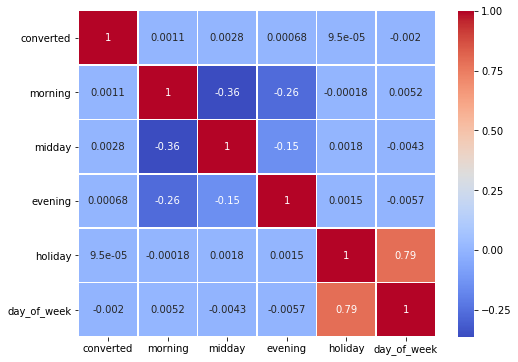

In [122]:
plt.figure(figsize = (8,6))
sns.heatmap(df_new[['converted','morning','midday','evening','holiday','day_of_week']].corr(),annot = True,
            linewidth = 0.5,cmap = 'coolwarm');

And again, we have strong non-corrlated relations with 'converted' variable,but if gather more data during two or more month, I think we might reveal some convertion patterns.


<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.